### Install modules in terminal

In [1]:
!pip install matplotlib seaborn numpy pandas xarray rioxarray geopandas rasterio pillow pyproj scikit-learn pystac-client planetary-computer tqdm stackstac odc.stac


[notice] A new release of pip available: 22.3.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


### Import modules

In [2]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data Science
import numpy as np
import pandas as pd

# Multi-dimensional arrays and datasets
import xarray as xr

# Geospatial raster data handling
import rioxarray as rxr

# Geospatial data analysis
import geopandas as gpd

# Geospatial operations
import rasterio
from rasterio import windows  
from rasterio import features  
from rasterio import warp
from rasterio.warp import transform_bounds 
from rasterio.windows import from_bounds 

# Image Processing
from PIL import Image

# Coordinate transformations
from pyproj import Proj, Transformer, CRS

# Feature Engineering
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Machine Learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Planetary Computer Tools
import pystac_client
import planetary_computer as pc
from pystac.extensions.eo import EOExtension as eo

# Others
import os
from tqdm import tqdm

# Import common GIS tools
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import rioxarray as rio
import rasterio
from matplotlib.cm import RdYlGn,jet,RdBu

# Import Planetary Computer tools
import stackstac
import pystac_client
import planetary_computer 
from odc.stac import stac_load


# Import config file
import config
import importlib
importlib.reload(config)

<module 'config' from 'c:\\Users\\winne\\Documents\\GitHub\\UHI\\config.py'>

### Fetch API

In [3]:
stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

### Data search (From different dataset)

In [4]:
landsat_search = stac.search(
    bbox=config.bounds, 
    datetime=config.time_window,
    collections=["landsat-c2-l2"],
    query={"eo:cloud_cover": {"lt": 50},"platform": {"in": ["landsat-8"]}},
)

landsat_items = list(landsat_search.get_items())
print('This is the number of scenes that touch our region:',len(landsat_items))

landsat_signed_items = [planetary_computer.sign(item).to_dict() for item in landsat_items]

landsat_resolution = 30  # meters per pixel 
landsat_scale = landsat_resolution / 111320.0 # degrees per pixel for crs=4326 

This is the number of scenes that touch our region: 8


### Data Load

In [5]:
landsat_data1 = stac_load(
    landsat_items,
    bands=["blue","green","red","nir08","swir16","swir22","coastal"],
    crs="EPSG:4326", # Latitude-Longitude
    resolution=landsat_scale, # Degrees
    chunks={"x": 2048, "y": 2048},
    dtype="uint16",
    patch_url=planetary_computer.sign,
    bbox=config.bounds
)

landsat_data2 = stac_load(
    landsat_items,
    bands=["lwir11"],
    crs="EPSG:4326", # Latitude-Longitude
    resolution=landsat_scale, # Degrees
    chunks={"x": 2048, "y": 2048},
    dtype="uint16",
    patch_url=planetary_computer.sign,
    bbox=config.bounds
)

### Extracting Data

In [6]:
# Persist the data in memory for faster operations
landsat_data1 = landsat_data1.persist()
landsat_data2 = landsat_data2.persist()

# Scale Factors for the RGB and NIR bands 
scale1 = 0.0000275 
offset1 = -0.2 
landsat_data1 = landsat_data1.astype(float) * scale1 + offset1

# Scale Factors for the Surface Temperature band
scale2 = 0.00341802 
offset2 = 149.0 
kelvin_celsius = 273.15 # convert from Kelvin to Celsius
landsat_data2 = landsat_data2.astype(float) * scale2 + offset2 - kelvin_celsius

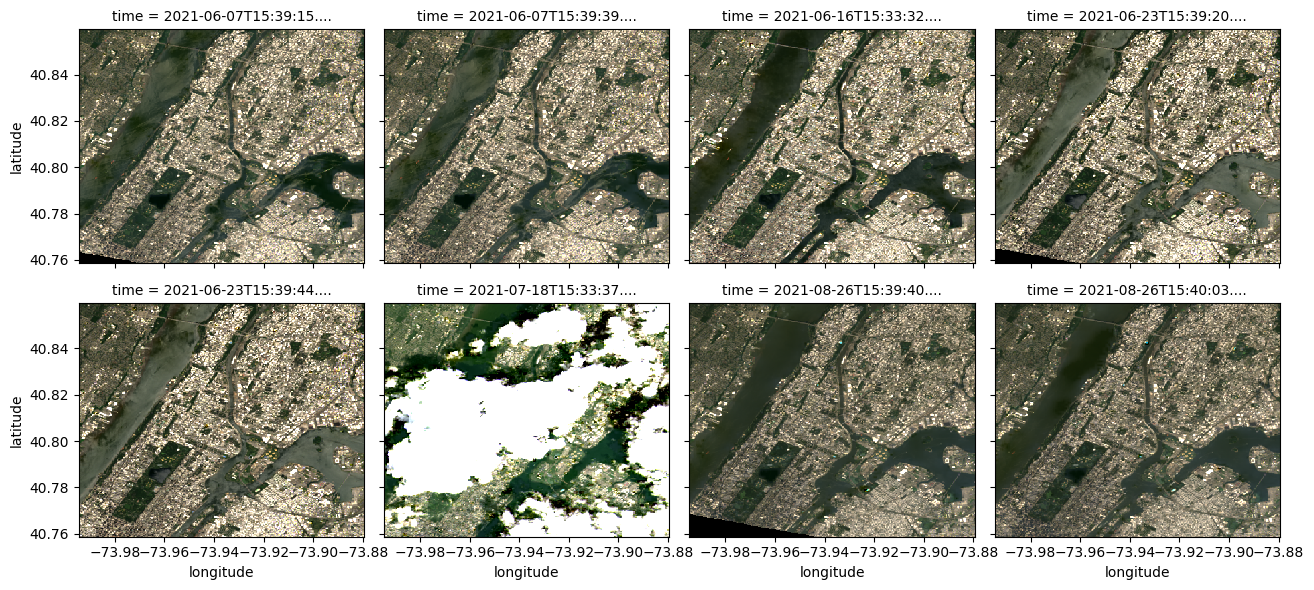

In [7]:
plot_landsat_data1 = landsat_data1[["red","green","blue"]].to_array()
plot_landsat_data1.plot.imshow(col='time', col_wrap=4, robust=True, vmin=0, vmax=0.25)
plt.show()

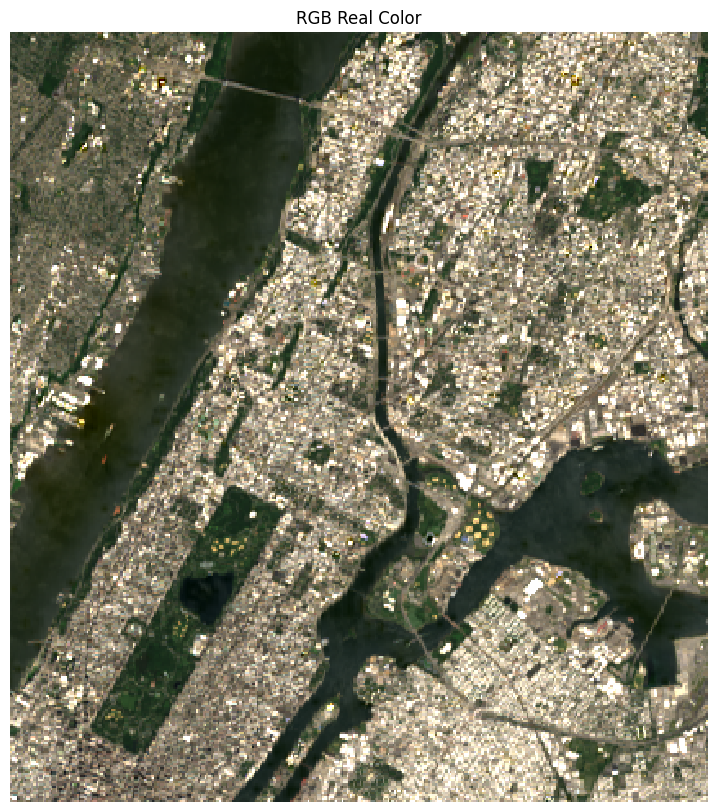

In [8]:
# Pick one of the scenes above (numbering starts with 0)
landsat_scene = 2

# Plot an RGB Real Color Image for a single date
fig, ax = plt.subplots(figsize=(9,10))
landsat_data1.isel(time=landsat_scene)[["red", "green", "blue"]].to_array().plot.imshow(robust=True, ax=ax, vmin=0.0, vmax=0.25)
ax.set_title("RGB Real Color")
ax.axis('off')
plt.show()

###### NDVI

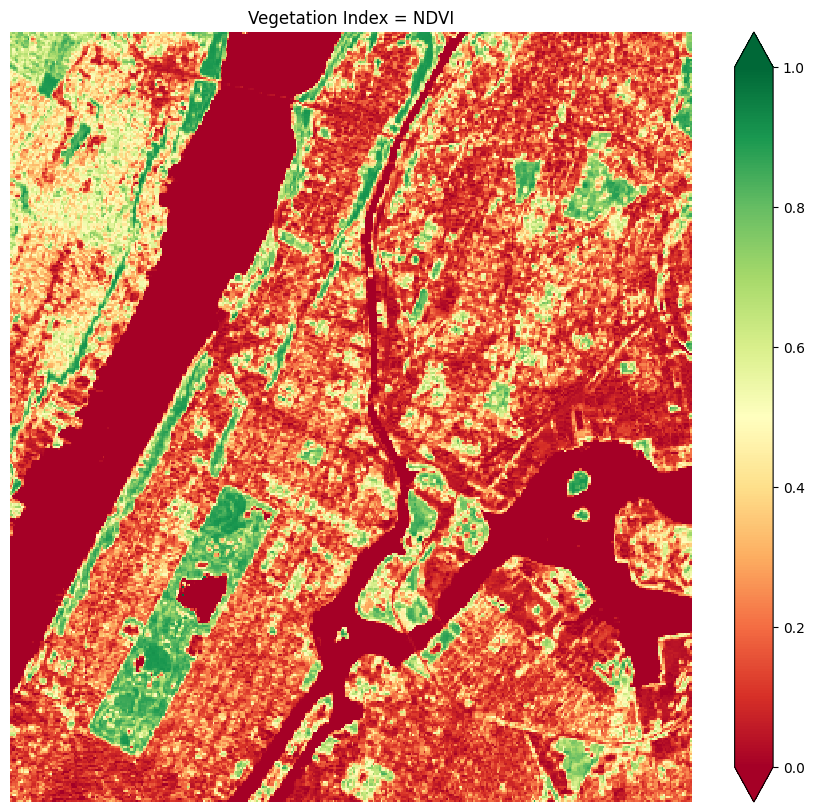

In [9]:
# Calculate NDVI for the median mosaic
landsat_ndvi_data = (landsat_data1.isel(time=landsat_scene).nir08-landsat_data1.isel(time=landsat_scene).red)/(landsat_data1.isel(time=landsat_scene).nir08+landsat_data1.isel(time=landsat_scene).red)

fig, ax = plt.subplots(figsize=(11,10))
landsat_ndvi_data.plot.imshow(vmin=0.0, vmax=1.0, cmap="RdYlGn")
plt.title("Vegetation Index = NDVI")
plt.axis('off')
plt.show()

###### LWIR11

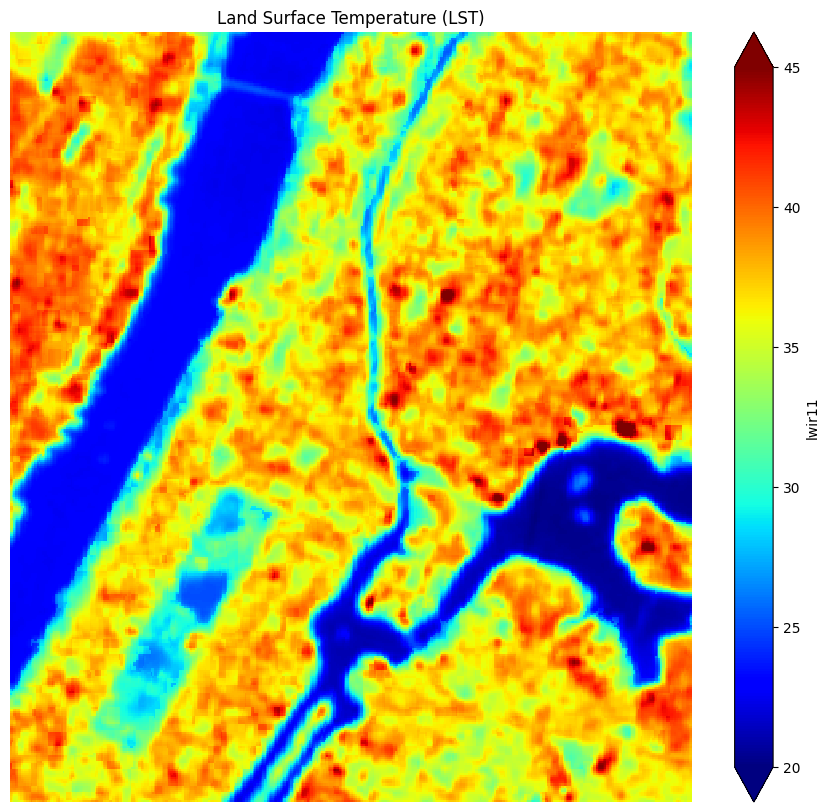

In [10]:
landsat_lwir11_data = landsat_data2.isel(time=landsat_scene).lwir11

fig, ax = plt.subplots(figsize=(11,10))
landsat_lwir11_data.plot.imshow(vmin=20.0, vmax=45.0, cmap="jet")
plt.title("Land Surface Temperature (LST)")
plt.axis('off')
plt.show()

### Processing Data

In [11]:
# Only select one of the time slices to output
landsat_data1_slice = landsat_data1.isel(time=landsat_scene)
landsat_data2_slice = landsat_data2.isel(time=landsat_scene)

In [12]:
landsat_data1_height =  landsat_data1_slice.dims["latitude"]
landsat_data1_width =  landsat_data1_slice.dims["longitude"]

landsat_data2_height =  landsat_data2_slice.dims["latitude"]
landsat_data2_width =  landsat_data2_slice.dims["longitude"]

#### Save dataset

In [13]:
# Define the Coordinate Reference System (CRS) to be common Lat-Lon coordinates
# Define the tranformation using our bounding box so the Lat-Lon information is written to the GeoTIFF
gt1 = rasterio.transform.from_bounds(config.lower_left[1],config.lower_left[0],config.upper_right[1],config.upper_right[0],landsat_data1_height,landsat_data1_width)

landsat_data1_slice.rio.write_crs("epsg:4326", inplace=True)
landsat_data1_slice.rio.write_transform(transform=gt1, inplace=True);

gt2 = rasterio.transform.from_bounds(config.lower_left[1],config.lower_left[0],config.upper_right[1],config.upper_right[0],landsat_data2_height,landsat_data2_width)

landsat_data2_slice.rio.write_crs("epsg:4326", inplace=True)
landsat_data2_slice.rio.write_transform(transform=gt2, inplace=True);


In [14]:
# Create the GeoTIFF output file using the defined parameters 
with rasterio.open(config.landsat1_tiff,'w',driver='GTiff',width=landsat_data1_width,height=landsat_data1_height,
                   crs='epsg:4326',transform=gt1,count=7,compress='lzw',dtype='float64') as dst:
    dst.write(landsat_data1_slice.blue,1)
    dst.write(landsat_data1_slice.green,2)
    dst.write(landsat_data1_slice.red,3)
    dst.write(landsat_data1_slice.nir08,4)
    dst.write(landsat_data1_slice.swir16,5)
    dst.write(landsat_data1_slice.swir22,6)
    dst.write(landsat_data1_slice.coastal,7)
    dst.close()


with rasterio.open(config.landsat2_tiff,'w',driver='GTiff',width=landsat_data2_width,height=landsat_data2_height,
                   crs='epsg:4326',transform=gt2,count=1,compress='lzw',dtype='float64') as dst:
    dst.write(landsat_data2_slice.lwir11,1)
    dst.close()